# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense, Bidirectional
from statsmodels.tsa.arima.model import ARIMA

# Data Exploration

## Loading dataset

In [2]:
# Load the Amazon stock price dataset
amazon_data = pd.read_csv('AMZN.csv')
amazon_data['Date'] = pd.to_datetime(amazon_data['Date'])
amazon_data.set_index('Date', inplace=True)

In [3]:
# Calculate daily percentage change
amazon_data['Price_diff'] = amazon_data['Close'].pct_change()
# Drop missing values
amazon_data.dropna(inplace=True)

# Methodology

## Building models

In [4]:
# Function to create sequences for RNN models
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [5]:
# Function to train and evaluate RNN models
def train_evaluate_rnn(X_train, y_train, X_val, y_val, model):
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))
    predictions = model.predict(X_val)
    return predictions

In [6]:
# Function to train and evaluate Linear Regression model
def train_evaluate_linear_regression(X_train, y_train, X_val, y_val):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    return predictions

In [7]:
# Function to train and evaluate ARIMA model
def train_evaluate_arima(data, order):
    model = ARIMA(data, order=order)
    fit_model = model.fit()
    predictions = fit_model.predict(start=len(data), end=len(data)+4, typ='levels')
    return predictions

In [8]:
# Split the dataset into train, validation, and test sets
train_size = int(len(amazon_data) * 0.7)
val_size = int(len(amazon_data) * 0.15)
test_size = len(amazon_data) - train_size - val_size

train_data = amazon_data[:train_size]
val_data = amazon_data[train_size:train_size + val_size]
test_data = amazon_data[train_size + val_size:]

In [9]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data['Price_diff'].values.reshape(-1, 1))
val_data_scaled = scaler.transform(val_data['Price_diff'].values.reshape(-1, 1))
test_data_scaled = scaler.transform(test_data['Price_diff'].values.reshape(-1, 1))

In [10]:
# Create sequences for RNN models
seq_length = 10
X_train, y_train = create_sequences(train_data_scaled, seq_length)
X_val, y_val = create_sequences(val_data_scaled, seq_length)
X_test, y_test = create_sequences(test_data_scaled, seq_length)

In [11]:
# Build and train RNN models for comparison (LSTM, Vanilla RNN, GRU, Bidirectional LSTM)
models = [
    ('LSTM', LSTM(50, activation='relu', input_shape=(seq_length, 1))),
    ('Vanilla_or_Simple_RNN', SimpleRNN(50, activation='relu', input_shape=(seq_length, 1))),
    ('GRU', GRU(50, activation='relu', input_shape=(seq_length, 1))),
    ('Bidirectional_LSTM', Bidirectional(LSTM(50, activation='relu'), input_shape=(seq_length, 1)))
]

In [12]:
# Build and training a different model for overall comparison (Linear Regression)
model_linear = LinearRegression()
model_linear.fit(X_train.reshape(-1, seq_length), y_train)
predictions_linear = model_linear.predict(X_test.reshape(-1, seq_length))
predictions_linear = scaler.inverse_transform(predictions_linear.reshape(-1, 1))

## Evaluate and compare RNN models with others

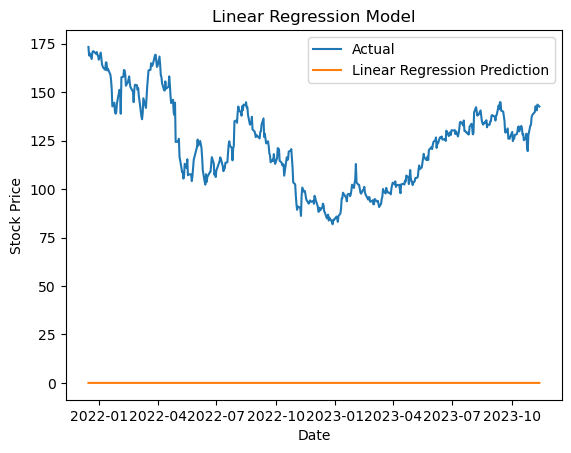

In [13]:
# Plot Linear Regression model predictions
plt.plot(test_data.index[seq_length:], test_data['Close'].values[seq_length:], label='Actual')
plt.plot(test_data.index[seq_length:], predictions_linear, label='Linear Regression Prediction')
plt.title('Linear Regression Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

C:\Users\aakan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aakan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aakan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aakan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


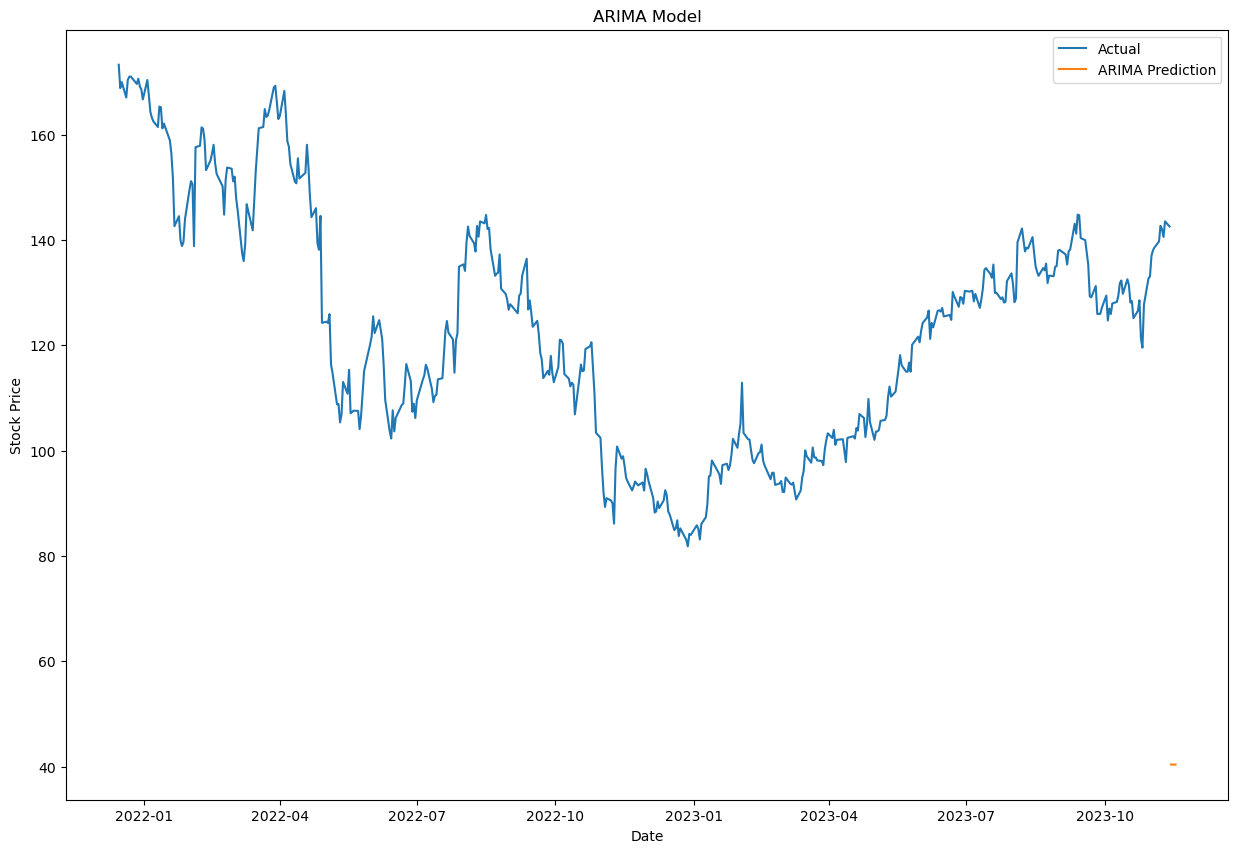

In [14]:
# Train and evaluate ARIMA model
order_arima = (5, 1, 0)  # Example ARIMA order, you can tune this based on your data
predictions_arima = train_evaluate_arima(amazon_data['Close'], order_arima)
# Plot ARIMA model predictions
plt.figure(figsize=(15, 10))
plt.plot(test_data.index[seq_length:], test_data['Close'].values[seq_length:], label='Actual')
# Create future dates for ARIMA
future_dates_arima = pd.date_range(test_data.index[-1], periods=5, freq='B')[1:]
# Print future predicted stock prices for ARIMA
future_predictions_arima = predictions_arima  # You may need to adjust this based on your ARIMA implementation
future_predictions_arima = scaler.inverse_transform(np.array(future_predictions_arima).reshape(-1, 1))
# Ensure future_dates_arima and future_predictions_arima have the same length
future_dates_arima = future_dates_arima[:len(future_predictions_arima)]
future_predictions_arima = future_predictions_arima[:len(future_dates_arima)]
plt.plot(future_dates_arima, future_predictions_arima, label='ARIMA Prediction')
plt.title('ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [15]:
predictions_rnn = {}
for model_name, rnn_layer in models:
    print(f"\nTraining and evaluating {model_name}:")
    model = Sequential()
    model.add(rnn_layer)
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')
    predictions = train_evaluate_rnn(X_train, y_train, X_test, y_test, model)
    predictions = scaler.inverse_transform(predictions)
    predictions_rnn[model_name] = predictions


Training and evaluating LSTM:
Epoch 1/50
72/72 [==============================] - 2s 7ms/step - loss: 0.1297 - val_loss: 0.0738
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 0.0489 - val_loss: 0.0733
Epoch 3/50
72/72 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0755
Epoch 4/50
72/72 [==============================] - 0s 4ms/step - loss: 0.0494 - val_loss: 0.0770
Epoch 5/50
72/72 [==============================] - 0s 4ms/step - loss: 0.0489 - val_loss: 0.0728
Epoch 6/50
72/72 [==============================] - 0s 4ms/step - loss: 0.0491 - val_loss: 0.0740
Epoch 7/50
72/72 [==============================] - 0s 4ms/step - loss: 0.0482 - val_loss: 0.0728
Epoch 8/50
72/72 [==============================] - 0s 3ms/step - loss: 0.0485 - val_loss: 0.0724
Epoch 9/50
72/72 [==============================] - 0s 4ms/step - loss: 0.0482 - val_loss: 0.0723
Epoch 10/50
72/72 [==============================] - 0s 4ms/step - loss: 0.0482 - val_l

72/72 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0723
Epoch 33/50
72/72 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0724
Epoch 34/50
72/72 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0767
Epoch 35/50
72/72 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0740
Epoch 36/50
72/72 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0720
Epoch 37/50
72/72 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0721
Epoch 38/50
72/72 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0721
Epoch 39/50
72/72 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0720
Epoch 40/50
72/72 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0725
Epoch 41/50
72/72 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0742
Epoch 42/50
72/72 [===

72/72 [==============================] - 0s 5ms/step - loss: 0.0473 - val_loss: 0.0714
Epoch 14/50
72/72 [==============================] - 0s 5ms/step - loss: 0.0470 - val_loss: 0.0713
Epoch 15/50
72/72 [==============================] - 0s 5ms/step - loss: 0.0471 - val_loss: 0.0710
Epoch 16/50
72/72 [==============================] - 0s 5ms/step - loss: 0.0475 - val_loss: 0.0713
Epoch 17/50
72/72 [==============================] - 0s 5ms/step - loss: 0.0470 - val_loss: 0.0710
Epoch 18/50
72/72 [==============================] - 0s 5ms/step - loss: 0.0470 - val_loss: 0.0719
Epoch 19/50
72/72 [==============================] - 0s 5ms/step - loss: 0.0470 - val_loss: 0.0709
Epoch 20/50
72/72 [==============================] - 0s 5ms/step - loss: 0.0469 - val_loss: 0.0708
Epoch 21/50
72/72 [==============================] - 0s 4ms/step - loss: 0.0467 - val_loss: 0.0707
Epoch 22/50
72/72 [==============================] - 0s 5ms/step - loss: 0.0470 - val_loss: 0.0720
Epoch 23/50
72/72 [===

### Visual representation and Predict stocks

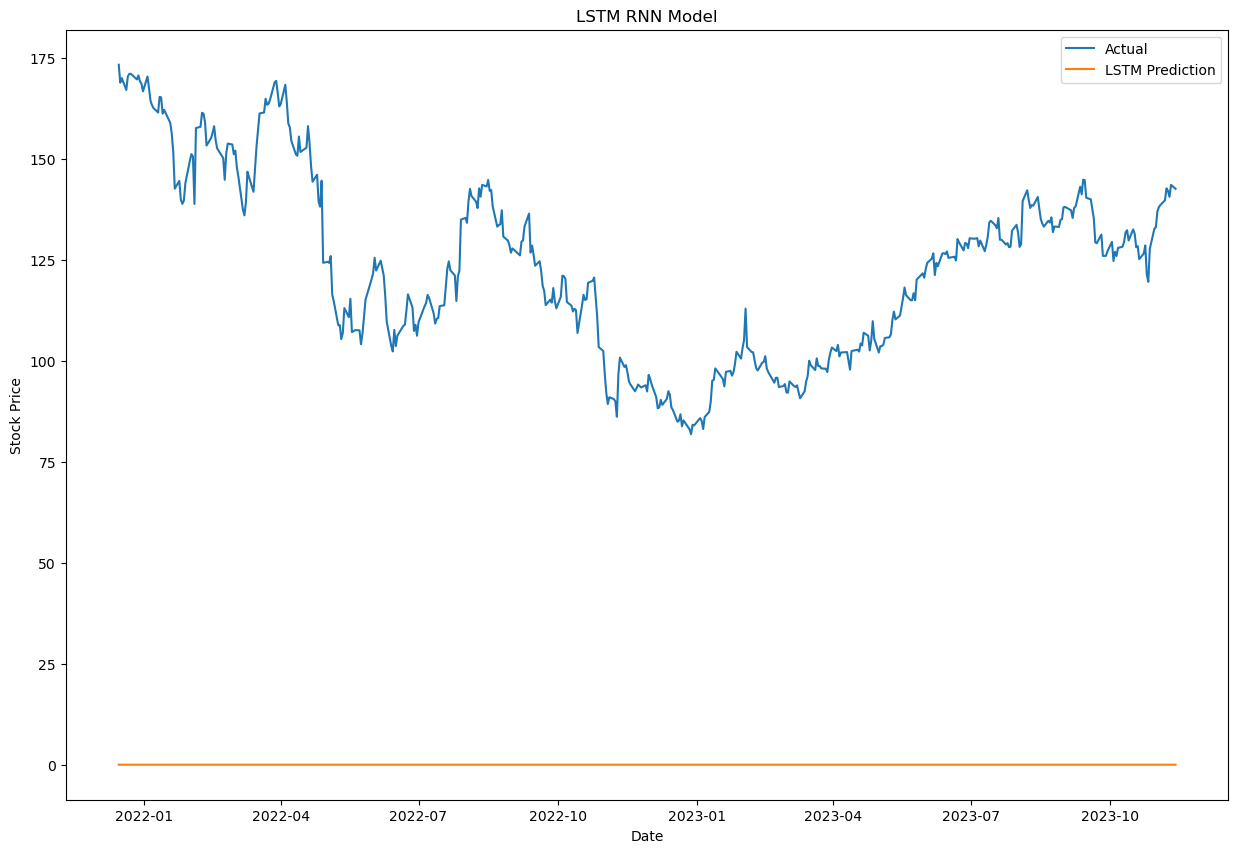

1/1 [==============================] - 0s 16ms/step

LSTM Future Predicted Stock Prices:
        Date  Predicted Price
0 2023-11-14         0.028525
1 2023-11-15         0.024111
2 2023-11-16         0.019665
3 2023-11-17         0.016827


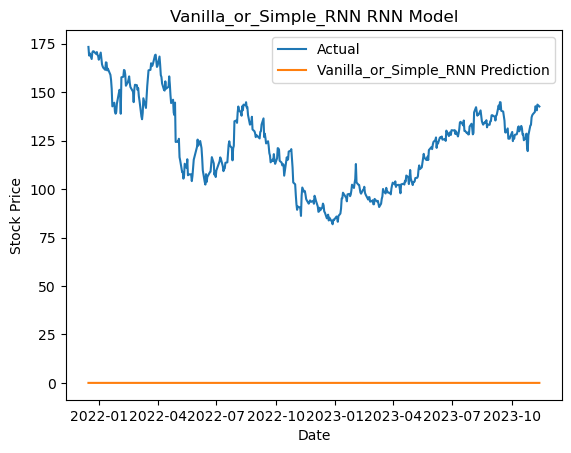

1/1 [==============================] - 0s 21ms/step

Vanilla_or_Simple_RNN Future Predicted Stock Prices:
        Date  Predicted Price
0 2023-11-14         0.028628
1 2023-11-15         0.024191
2 2023-11-16         0.019727
3 2023-11-17         0.016883


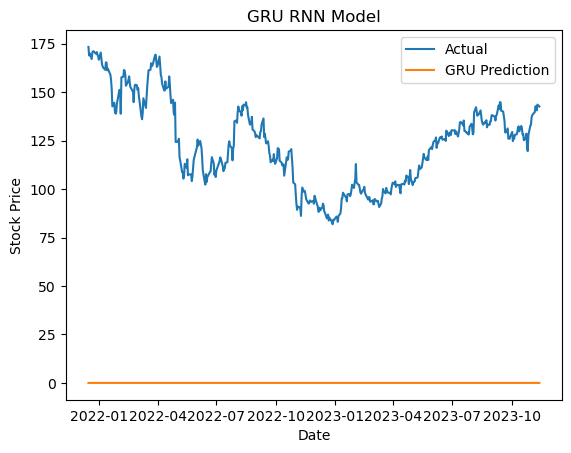

1/1 [==============================] - 0s 21ms/step

GRU Future Predicted Stock Prices:
        Date  Predicted Price
0 2023-11-14         0.028591
1 2023-11-15         0.024159
2 2023-11-16         0.019700
3 2023-11-17         0.016857


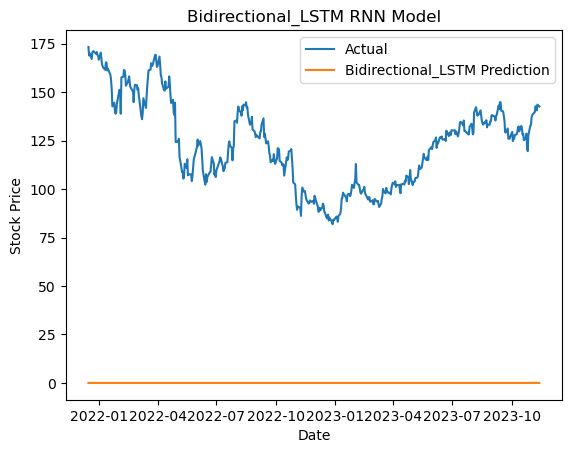

1/1 [==============================] - 0s 22ms/step

Bidirectional_LSTM Future Predicted Stock Prices:
        Date  Predicted Price
0 2023-11-14         0.028564
1 2023-11-15         0.024134
2 2023-11-16         0.019678
3 2023-11-17         0.016837


In [16]:
# Plot and print future predicted stock prices
plt.figure(figsize=(15, 10))
# Plot RNN model predictions
for model_name in predictions_rnn:
    plt.plot(test_data.index[seq_length:], test_data['Close'].values[seq_length:], label='Actual')
    plt.plot(test_data.index[seq_length:], predictions_rnn[model_name], label=f'{model_name} Prediction')
    plt.title(f'{model_name} RNN Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Print future predicted stock prices
    future_dates = pd.date_range(test_data.index[-1], periods=5, freq='B')[1:]
    future_inputs = np.concatenate([test_data_scaled[-seq_length+1:], predictions_rnn[model_name][-seq_length+1:]])

    future_predictions = []

    for _ in range(5):
        future_sequence = future_inputs[-seq_length:].reshape(1, seq_length, 1)
        future_prediction = model.predict(future_sequence)
        future_inputs = np.concatenate([future_inputs, future_prediction.flatten()[None]])
        future_predictions.append(scaler.inverse_transform(future_prediction)[0, 0])

    # Ensure future_dates and future_predictions have the same length
    future_dates = future_dates[:len(future_predictions)]
    future_predictions = future_predictions[:len(future_dates)]

    print(f"\n{model_name} Future Predicted Stock Prices:")
    future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions})
    print(future_predictions_df)